In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import arff
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

# (a) Download the Vertebral Column Data Set from: https://archive.ics.uci. edu/ml/datasets/Vertebral+Column.

In [2]:
#Loading the datasets
_2c = arff.loadarff("../data/column_2C_weka.arff")
df = pd.DataFrame(_2c[0])
_3c = arff.loadarff("../data/column_3C_weka.arff")
df_3c = pd.DataFrame(_3c[0])

In [3]:
#Checking for NULL values
print(df.isna().sum())
df.head(10)

pelvic_incidence            0
pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
class                       0
dtype: int64


,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,b'Abnormal'
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,b'Abnormal'
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,b'Abnormal'
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,b'Abnormal'
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,b'Abnormal'
5,40.250200,13.921907,25.124950,26.328293,130.327871,2.230652,b'Abnormal'
6,53.432928,15.864336,37.165934,37.568592,120.567523,5.988551,b'Abnormal'
7,45.366754,10.755611,29.038349,34.611142,117.270067,-10.675871,b'Abnormal'
8,43.790190,13.533753,42.690814,30.256437,125.002893,13.289018,b'Abnormal'
9,36.686353,5.010884,41.948751,31.675469,84.241415,0.664437,b'Abnormal'


In [4]:
#Evaluating classes in the two datasets
print(f"{df['class'].value_counts()}")
# print("*" * 40)
# print(f"DF_3C {df_3c['class'].value_counts()}")

b'Abnormal'    210
b'Normal'      100
Name: class, dtype: int64


In [5]:
#Replacing NO = 0 and AB = 1.
df['class'] = df["class"].str.decode('utf-8') #removing leading b' from string
df.loc[df['class'] == "Abnormal", "class"] = 1
df.loc[df['class'] == "Normal", "class"] = 0

In [6]:
print(f"{df['class'].value_counts()}")

1    210
0    100
Name: class, dtype: int64


# (b) Pre-Processing and Exploratory data analysis:

## i. Make scatterplots of the independent variables in the dataset. Use color to show Classes 0 and 1.

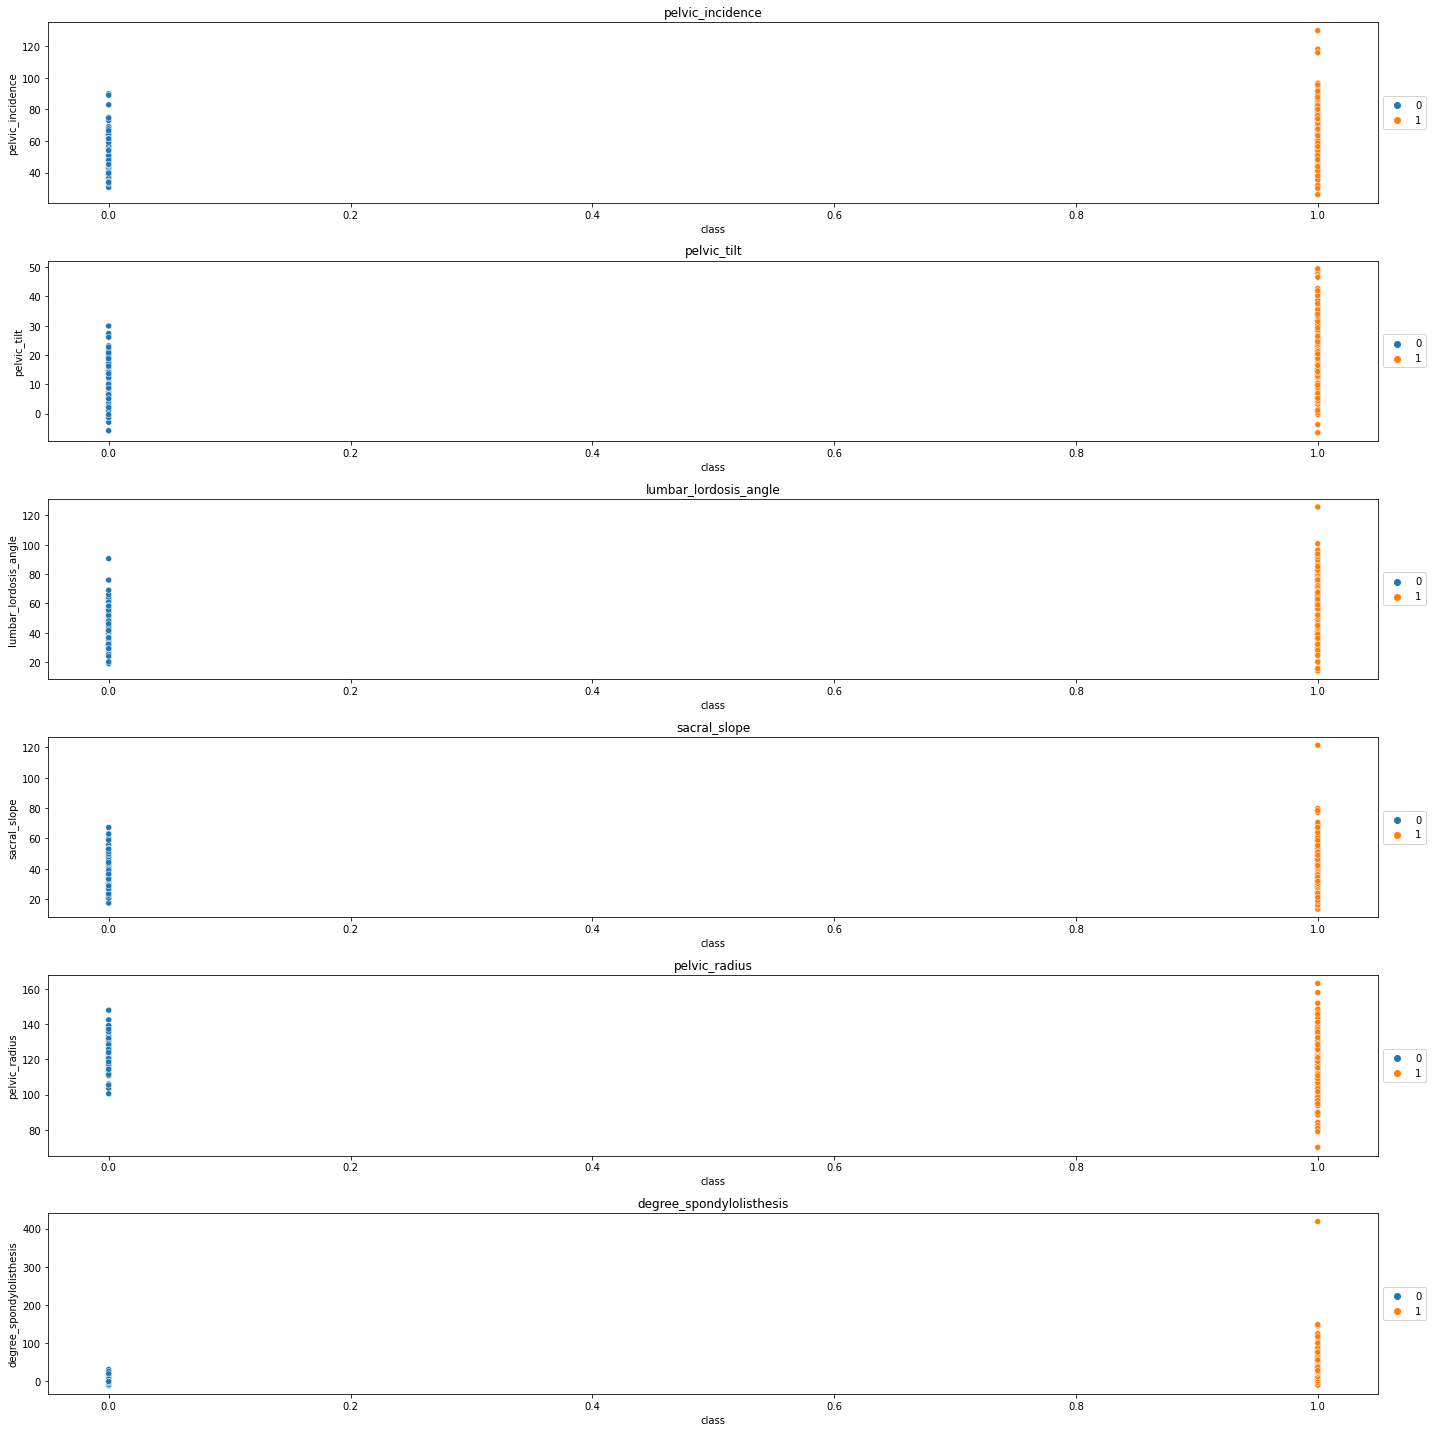

In [7]:
independent_vars = [col for col in df.columns if col != "class"]
fig, axs = plt.subplots(len(independent_vars),figsize=(20,20))
for i in range(len(independent_vars)):
    axs[i].set_title(f'{independent_vars[i]}')
    sns.scatterplot(x='class', y=f'{independent_vars[i]}', data=df, hue='class', ax=axs[i])
    axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

## ii. Make boxplots for each of the independent variables. Use color to show Classes 0 and 1 (see ISLR p. 129).

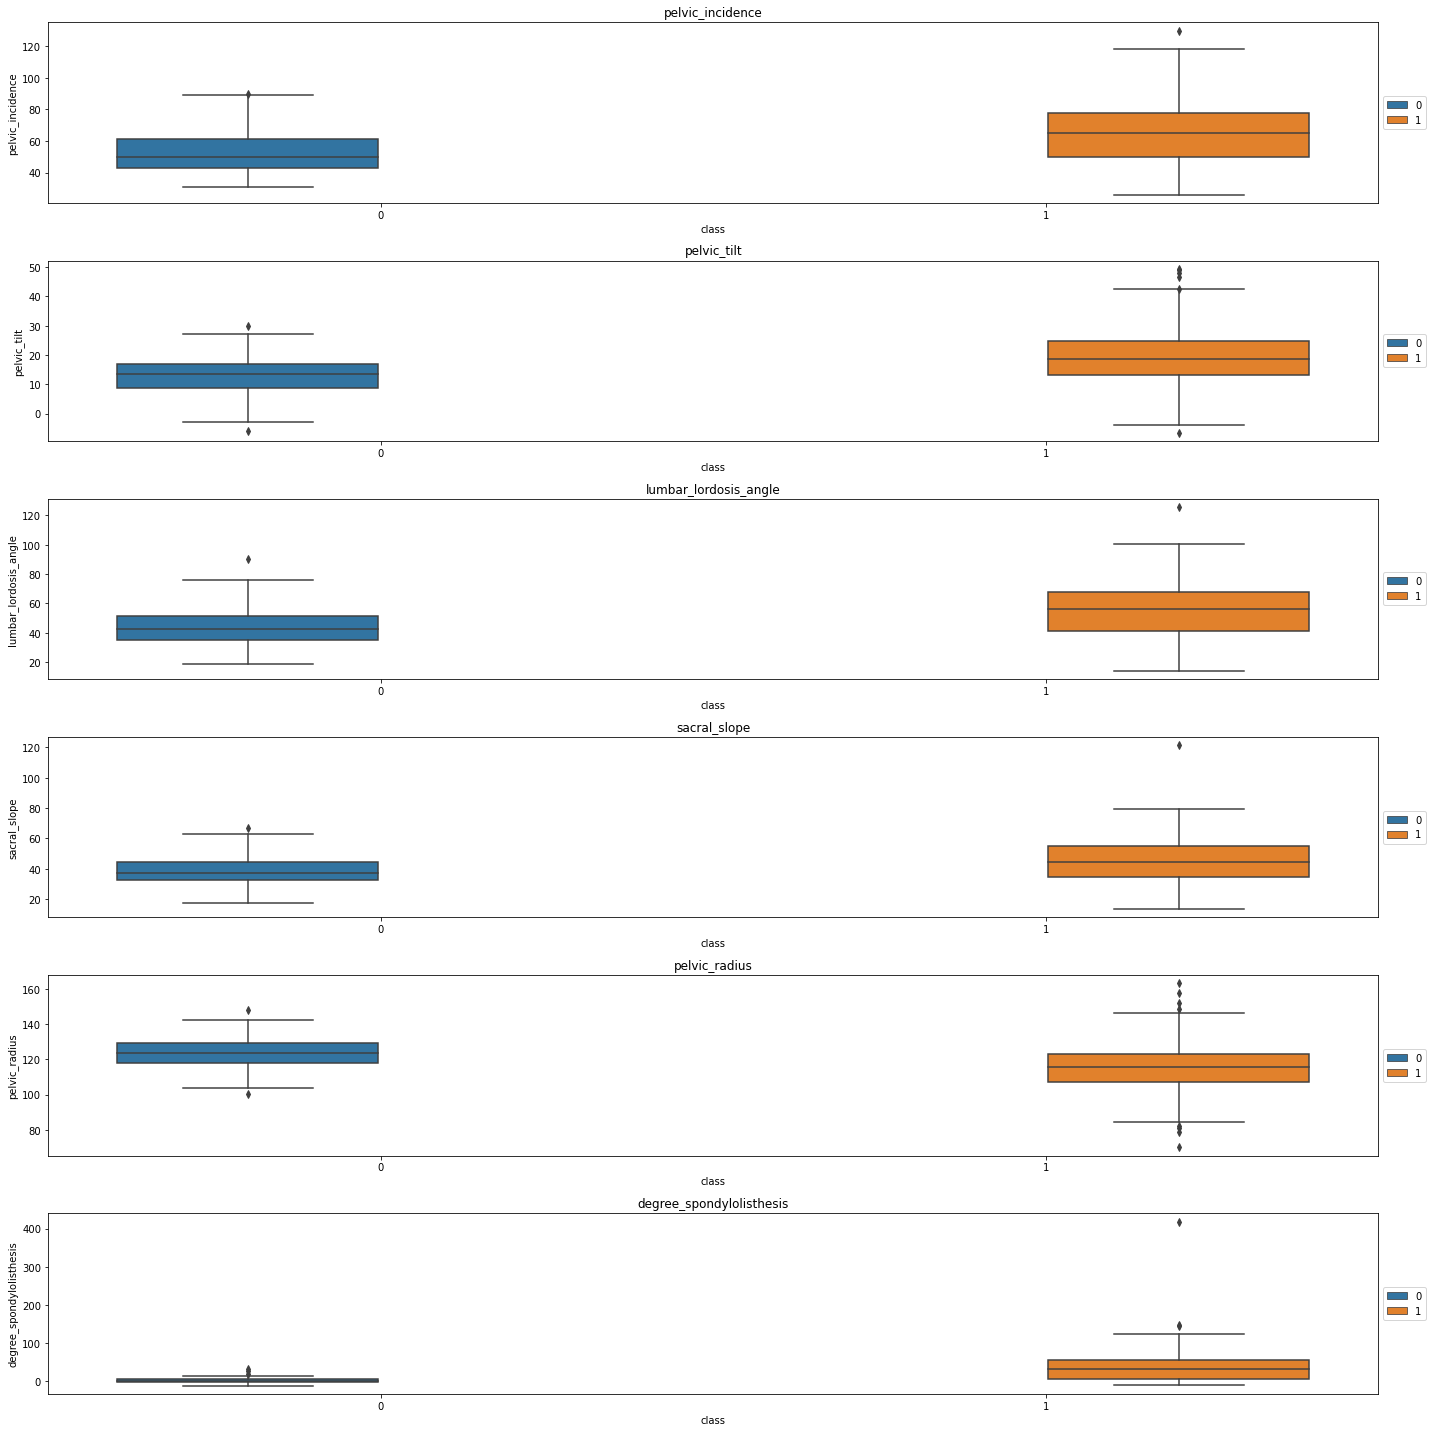

In [8]:
fig, axs = plt.subplots(len(independent_vars),figsize=(20,20))
for i in range(len(independent_vars)):
    axs[i].set_title(f'{independent_vars[i]}')
    sns.boxplot(x='class', y=f'{independent_vars[i]}', data=df, hue='class', ax=axs[i])
    axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

## iii. Select the first 70 rows of Class 0 and the first 140 rows of Class 1 as the training set and the rest of the data as the test set.

In [9]:
df_groups = df.groupby(by="class")
for key, group in df_groups:
    if key == 0:
        # normal group
        df_normal_train = group.iloc[:70]
        df_normal_test = group.iloc[70:]
    else:
        # abnormal group
        df_abnormal_train = group.iloc[:140]
        df_abnormal_test = group.iloc[140:]

In [10]:
df_train = pd.concat([df_normal_train, df_abnormal_train])
df_test = pd.concat([df_normal_test, df_abnormal_test])
print(f"Train Shape: {df_train.shape} || Test Shape: {df_test.shape}")

Train Shape: (210, 7) || Test Shape: (100, 7)


In [11]:
print(f"Train Value Counts: \n {df_train['class'].value_counts()} \n Test Value Counts: \n {df_test['class'].value_counts()}")


Train Value Counts: 
 1    140
0     70
Name: class, dtype: int64 
 Test Value Counts: 
 1    70
0    30
Name: class, dtype: int64


In [12]:
X_train, y_train = df_train.iloc[:, 0:-1], df_train.iloc[:, -1]
X_test, y_test = df_test.iloc[:,0:-1], df_test.iloc[:,-1]
#y needs to converted from object to int for KNN classifier to work properly
y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [13]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# (c) Classification using KNN on Vertebral Column Data Set

## i. Write code for k-nearest neighbors with Euclidean metric (or use a software package).

In [14]:
cls = KNeighborsClassifier(n_neighbors=1, metric='euclidean', n_jobs=-1)

## ii. Test all the data in the test database with k nearest neighbors. Take de- cisions by majority polling. Plot train and test errors in terms of k for k ∈ {208, 205, . . . , 7, 4, 1, } (in reverse order). You are welcome to use smaller increments of k. Which k∗ is the most suitable k among those values? Cal- culate the confusion matrix, true positive rate, true negative rate, precision, and F1-score when k = k∗.2

In [15]:
x_axis = [num for num in range(208, -1, -3)]
train_scores = []
test_scores = []
min_k, min_error = float("inf"), float("inf")

for k in range(208, -1, -3):
    cls = KNeighborsClassifier(n_neighbors=k, metric='euclidean', n_jobs=-1)
    cls.fit(X_train, y_train)
    y_pred_train = cls.predict(X_train)
    train_error = 1 - metrics.accuracy_score(y_train, y_pred_train)
    y_hat = cls.predict(X_test)
    test_error = 1 - metrics.accuracy_score(y_test,y_hat)
    train_scores.append(train_error)
    test_scores.append(test_error)
    if test_error < min_error:
        min_error = test_error
        min_k = k
#     train_test_scores[k] = [train_error, test_error]

print(len(train_scores) == len(test_scores) == len(x_axis))
print(f"Optimal Value of K={min_k} and lowest test error obtained={min_error}")

True
Optimal Value of K=4 and lowest test error obtained=0.12


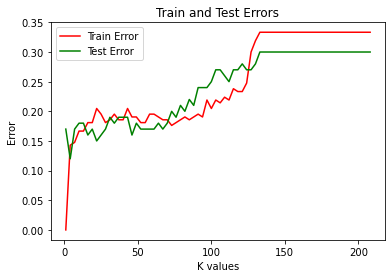

In [16]:
plt.plot(x_axis, train_scores, color='r', label='Train Error')
plt.plot(x_axis, test_scores, color='g', label='Test Error')
plt.xlabel("K values")
plt.ylabel("Error")
plt.title("Train and Test Errors")
plt.legend()

In [17]:
cls_euclid = KNeighborsClassifier(n_neighbors=min_k, metric='euclidean', n_jobs=-1)
cls_euclid.fit(X_train, y_train)
y_hat_euclid = cls_euclid.predict(X_test)
#POS = 1, NEG = 0
print(f"Confusion Matrix = \n {metrics.confusion_matrix(y_test, y_hat_euclid)}")
tp, tn, fp, fn = 0, 0, 0, 0
y_test_array = y_test.values.flatten()
y_hat_array = y_hat_euclid.flatten()
for i in range(len(y_hat_array)):
    actual = y_test_array[i]
    pred = y_hat_array[i]
    if actual == 1 and pred == 1:
        tp += 1
    elif actual == 0 and pred == 0:
        tn += 1
    elif actual == 0 and pred == 1:
        fp += 1
    elif actual == 1 and pred == 0:
        fn += 1
print(f"TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}")
# tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_hat_euclid).ravel()
total = tn + fp +  fn + tp
precision, recall = tp/(tp + fp), tp/(tp + fn)
print(f"True Positive Rate = {tp/(tp + fn)}")
print(f"True Negative Rate = {tn/(fp + tn)}")
print(f"Precision Score = {precision}")
print(f"Recall Score = {recall}")
print(f"F1 Score = {2 * (precision * recall) / (precision + recall)}")

Confusion Matrix = 
 [[22  8]
 [ 4 66]]
TN = 22, FP = 8, FN = 4, TP = 66
True Positive Rate = 0.9428571428571428
True Negative Rate = 0.7333333333333333
Precision Score = 0.8918918918918919
Recall Score = 0.9428571428571428
F1 Score = 0.9166666666666667


Sample Train Set Shape = (10, 7)
Sample Train Set Shape = (20, 7)
Sample Train Set Shape = (30, 7)
Sample Train Set Shape = (40, 7)
Sample Train Set Shape = (50, 7)
Sample Train Set Shape = (60, 7)
Sample Train Set Shape = (70, 7)
Sample Train Set Shape = (80, 7)
Sample Train Set Shape = (90, 7)
Sample Train Set Shape = (100, 7)
Sample Train Set Shape = (110, 7)
Sample Train Set Shape = (120, 7)
Sample Train Set Shape = (130, 7)
Sample Train Set Shape = (140, 7)
Sample Train Set Shape = (150, 7)
Sample Train Set Shape = (160, 7)
Sample Train Set Shape = (170, 7)
Sample Train Set Shape = (180, 7)
Sample Train Set Shape = (190, 7)
Sample Train Set Shape = (200, 7)
Sample Train Set Shape = (210, 7)
Minimum Test Error: 0.15000000000000002


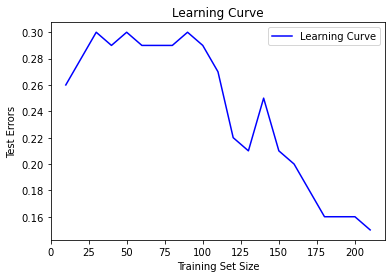

In [18]:
training_vals = [N for N in range(10,220,10)]
test_errors = []
for N in range(10,220,10):
    norm_num_rows = math.floor(N / 3)
    abnorm_num_rows = N - norm_num_rows

    df_groups = df_train.groupby(by="class")
    for key, group in df_groups:
        if key == 0:
            # normal group
            df_normal_train = group.iloc[:norm_num_rows]
        else:
            # abnormal group
            df_abnormal_train = group.iloc[:abnorm_num_rows]
    df_sample = pd.concat([df_normal_train, df_abnormal_train])
    print(f"Sample Train Set Shape = {df_sample.shape}")

    X_sample_train, y_sample_train = df_sample.iloc[:, 0:-1], df_sample.iloc[:, -1]
    X_sample_train = scaler.transform(X_sample_train)
    y_sample_train = y_sample_train.astype('int')
        
    min_k, min_error = float("inf"), float("inf")
    for k in range(1, N, 5):
        cls = KNeighborsClassifier(n_neighbors=k, metric='euclidean', n_jobs=-1)
        cls.fit(X_sample_train, y_sample_train)
        y_hat = cls.predict(X_test)
        test_error = 1 - metrics.accuracy_score(y_test,y_hat)
        if test_error < min_error:
            min_error = test_error
            min_k = k
    test_errors.append(min_error)

print(f"Minimum Test Error: {min(test_errors)}")
plt.plot(training_vals, test_errors, color='b', label='Learning Curve')
plt.xlabel("Training Set Size")
plt.ylabel("Test Errors")
plt.title("Learning Curve")
plt.legend()

# (d) Replace the Euclidean metric with the following metrics5 and test them. Sum- marize the test errors (i.e., when k = k∗) in a table. Use all of your training data and select the best k when {1,6,11,...,196}.

In [19]:
df_rows = []

## i. Minkowski Distance: A. which becomes Manhattan Distance with p = 1.

In [20]:
min_k_man, min_error_man = float("inf"), float("inf")
for k in range(1, 200, 5):
    cls = KNeighborsClassifier(n_neighbors=k, metric='minkowski',p=1, n_jobs=-1)
    cls.fit(X_train, y_train)
    y_hat = cls.predict(X_test)
    test_error = 1 - metrics.accuracy_score(y_test,y_hat)
    if test_error < min_error_man:
        min_error_man = test_error
        min_k_man = k
print(f"Minkowski with p=1 (Manhattan): \n K = K* = {min_k_man} \n Best Test Error = {min_error_man}")
df_rows.append(["Minkowski (p=1) Manhattan", min_k_man, min_error_man])

Minkowski with p=1 (Manhattan): 
 K = K* = 6 
 Best Test Error = 0.14


## i. Minkowski Distance: B. with log10(p) ∈ {0.1,0.2,0.3,...,1}. In this case, use the k∗ you found for the Manhattan distance in 1(d)iA. What is the best log10(p)?

In [21]:
min_k_mink, min_error_mink, bestlogp = float("inf"), float("inf"), None
for logp in np.arange(0.1,1.1,0.1):
    p = pow(10,logp)
    cls = KNeighborsClassifier(n_neighbors=min_k_man, metric='minkowski',p=p, n_jobs=-1)
    cls.fit(X_train, y_train)
    y_hat = cls.predict(X_test)
    test_error = 1 - metrics.accuracy_score(y_test,y_hat)
    if test_error < min_error_mink:
        min_error_mink = test_error
        min_k_mink = k
        bestlogp = logp
print(f"Minkowski Distance: \n K = K* = {min_k_mink} \n Best Test Error = {min_error_mink} \n Best Log(p) = {bestlogp}")
df_rows.append(["Minkowski Distance", min_k_mink, min_error_mink])

Minkowski Distance: 
 K = K* = 196 
 Best Test Error = 0.16000000000000003 
 Best Log(p) = 0.4


## i. Minkowski Distance: C. which becomes Chebyshev Distance with p → ∞

In [22]:
min_k_cheb, min_error_cheb = float("inf"), float("inf")
for k in range(1, 200, 5):
    cls = KNeighborsClassifier(n_neighbors=k, metric='minkowski',p=float('inf'), n_jobs=-1)
    cls.fit(X_train, y_train)
    y_hat = cls.predict(X_test)
    test_error = 1 - metrics.accuracy_score(y_test,y_hat)
    if test_error < min_error_cheb:
        min_error_cheb = test_error
        min_k_cheb = k
print(f"Minkowski with p=inf (Chebyshev): \n K = K* = {min_k_cheb} \n Best Test Error = {min_error_cheb}")
df_rows.append(["Minkowski (p=∞) Chebyshev", min_k_cheb, min_error_cheb])

Minkowski with p=inf (Chebyshev): 
 K = K* = 1 
 Best Test Error = 0.15000000000000002


## ii. Mahalanobis Distance.

In [23]:
min_k_mahal, min_error_mahal = float("inf"), float("inf")
for k in range(1, 200, 5):
    cls = KNeighborsClassifier(n_neighbors=k, metric='mahalanobis',metric_params={'VI': np.linalg.inv(np.cov(X_train.T))}, n_jobs=-1)
    cls.fit(X_train, y_train)
    y_hat = cls.predict(X_test)
    test_error = 1 - metrics.accuracy_score(y_test,y_hat)
    if test_error < min_error_mahal:
        min_error_mahal = test_error
        min_k_mahal = k
print(f"Mahalanobis Distance: \n K = K* = {min_k_mahal} \n Best Test Error = {min_error_mahal}")
df_rows.append(["Mahalanobis Distance", min_k_mahal, min_error_mahal])

Mahalanobis Distance: 
 K = K* = 1 
 Best Test Error = 0.16000000000000003


In [24]:
df_display = pd.DataFrame(df_rows, columns=['Metric', 'K=K*', 'Best Test Error'])
df_display

,Metric,K=K*,Best Test Error
0,Minkowski (p=1) Manhattan,6,0.14
1,Minkowski Distance,196,0.16
2,Minkowski (p=∞) Chebyshev,1,0.15
3,Mahalanobis Distance,1,0.16


# (e) The majority polling decision can be replaced by weighted decision, in which the weight of each point in voting is inversely proportional to its distance from the query/test data point. In this case, closer neighbors of a query point will have a greater influence than neighbors which are further away. Use weighted voting with Euclidean, Manhattan, and Chebyshev distances and report the best test errors when k ∈ {1,6,11,16,...,196}.

In [25]:
min_k_euc_weighted, min_error_euc_weighted = float("inf"), float("inf")
for k in range(1, 200, 5):
    cls = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean', n_jobs=-1)
    cls.fit(X_train, y_train)
    y_hat = cls.predict(X_test)
    test_error = 1 - metrics.accuracy_score(y_test,y_hat)
    if test_error < min_error_euc_weighted:
        min_error_euc_weighted = test_error
        min_k_euc_weighted = k
print(f"Weighted KNN Classifier - Euclidean: K=K* {min_k_euc_weighted}, Best Test Error = {min_error_euc_weighted} \n")

min_k_man_weighted, min_error_man_weighted = float("inf"), float("inf")
for k in range(1, 200, 5):
    cls = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='minkowski', p=1, n_jobs=-1)
    cls.fit(X_train, y_train)
    y_hat = cls.predict(X_test)
    test_error = 1 - metrics.accuracy_score(y_test,y_hat)
    if test_error < min_error_man_weighted:
        min_error_man_weighted = test_error
        min_k_man_weighted = k
print(f"Weighted KNN Classifier - Manhattan: K=K* {min_k_man_weighted}, Best Test Error = {min_error_man_weighted} \n")

min_k_cheb_weighted, min_error_cheb_weighted = float("inf"), float("inf")
for k in range(1, 200, 5):
    cls = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='minkowski', p=float('inf'), n_jobs=-1)
    cls.fit(X_train, y_train)
    y_hat = cls.predict(X_test)
    test_error = 1 - metrics.accuracy_score(y_test,y_hat)
    if test_error < min_error_cheb_weighted:
        min_error_cheb_weighted = test_error
        min_k_cheb_weighted = k
print(f"Weighted KNN Classifier - Chebyshev: K=K* {min_k_cheb_weighted}, Best Test Error = {min_error_cheb_weighted} \n")


Weighted KNN Classifier - Euclidean: K=K* 21, Best Test Error = 0.15000000000000002 

Weighted KNN Classifier - Manhattan: K=K* 6, Best Test Error = 0.15000000000000002 

Weighted KNN Classifier - Chebyshev: K=K* 1, Best Test Error = 0.15000000000000002 



# (f) What is the lowest training error rate you achieved in this homework?

In [27]:
print(f"Lowest Training Error achieved in KNN = {min(train_scores)}")

Lowest Training Error achieved in KNN = 0.0
